In [1]:
from __future__ import print_function

import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
batch_size = 8
epochs = 6
lr = 1e-5
gamma = 0.8
seed = 42


def seed_everything(seed):
    """
    Sets the random seed for reproducibility in python, numpy, and torch.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device used :", device)

Device used : cuda


In [3]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name()}")
print(f"GPU memory allocated: {torch.cuda.memory_allocated()}")
print(f"GPU memory cached: {torch.cuda.memory_reserved()}")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce GTX 1070 with Max-Q Design
GPU memory allocated: 0
GPU memory cached: 0


In [ ]:
# Paths to the dataset
base_dir = './dataset'
train_csv_path = os.path.join(base_dir, 'train.csv')
test_csv_path  = os.path.join(base_dir, 'test.csv')

# Reading the training CSV file
df_train = pd.read_csv(train_csv_path)
# Example of a row: file_name="train_data/041be3153810...", label=0 or 1

# Reading the testing CSV file
df_test = pd.read_csv(os.path.join(base_dir, 'test.csv'))
# Exemple: df_test['id'] = "test_data/e25323c62af644fba97afb846261b05b.jpg", etc.

# Adding the full path to the file_name instead of just "trainORtest_data/xxx.jpg"
df_test['id'] = df_test['id'].apply(lambda x: os.path.join(base_dir, x))
df_train['file_name'] = df_train['file_name'].apply(lambda x: os.path.join(base_dir, x))

all_image_paths = df_train['file_name'].values
all_labels = df_train['label'].values

# Splitting train/validation (95% / 5%)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths,
    all_labels,
    test_size=0.05,        
    stratify=all_labels,
    random_state=seed
)

print(f"Train Data: {len(train_paths)}")
print(f"Validation Data: {len(val_paths)}")

Train Data: 75952
Validation Data: 3998


In [5]:
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

train_transforms = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.BICUBIC),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

val_transforms = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

test_transforms = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

In [6]:
class ImageDataset(Dataset):
    """
    Generic dataset for loading images and their labels (optional).
    If labels=None, we assume we're in inference/test mode without labels.
    """
    def __init__(self, file_list, labels=None, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            label = self.labels[idx]
            return img, label
        else:
            return img

class TestImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(img_path) 

In [7]:
train_data = ImageDataset(train_paths, train_labels, transform=train_transforms)
val_data   = ImageDataset(val_paths,   val_labels,   transform=val_transforms)

train_loader = DataLoader(
    dataset=train_data, 
    batch_size=batch_size, 
    shuffle=True,  
    num_workers=0,  
    pin_memory=True,
    persistent_workers=False
)

val_loader = DataLoader(
    dataset=val_data,   
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True,
    persistent_workers=False
)

print(f"Train Dataset size: {len(train_data)}")
print(f"Validation Dataset size: {len(val_data)}")

Train Dataset size: 75952
Validation Dataset size: 3998


In [8]:
# Load pre-trained Regnet
model = models.regnet_y_32gf(weights=models.RegNet_Y_32GF_Weights.IMAGENET1K_SWAG_E2E_V1)

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(232, 232, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1):

In [9]:
# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1s = []

In [10]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    
    print(f"Starting epoch {epoch+1}")
    print(f"Number of batches: {len(train_loader)}")
    
    # Clear GPU cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    for i, (data, label) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        if i == 0:
            print(f"First batch shape: {data.shape}")
            print(f"First batch device: {data.device}")
            print(f"GPU memory after first batch: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
            
        # Move data to GPU asynchronously
        data = data.to(device, non_blocking=True)
        label = label.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        preds = output.argmax(dim=1)
        acc = (preds == label).float().mean().item()
        epoch_accuracy += acc

    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(train_loader)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # -- Validation --
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_pred_classes = []
    val_labels_list = []

    with torch.no_grad():
        for data, label in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            data, label = data.to(device), label.to(device)
            output = model(data)

            loss = criterion(output, label)
            val_loss += loss.item()

            preds = output.argmax(dim=1)
            acc = (preds == label).float().mean().item()
            val_acc += acc

            val_pred_classes.extend(preds.cpu().numpy())
            val_labels_list.extend(label.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    
    val_f1 = f1_score(val_labels_list, val_pred_classes)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}"
    )

    scheduler.step()

Starting epoch 1
Number of batches: 9494


Training Epoch 1:   0%|          | 0/9494 [00:00<?, ?it/s]

First batch shape: torch.Size([8, 3, 224, 224])
First batch device: cpu
GPU memory after first batch: 551.83 MB


Validation Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/6] Train Loss: 0.0366 | Train Acc: 0.9867 | Val Loss: 0.0092 | Val Acc: 0.9980 | Val F1: 0.9980
Starting epoch 2
Number of batches: 9494


Training Epoch 2:   0%|          | 0/9494 [00:00<?, ?it/s]

First batch shape: torch.Size([8, 3, 224, 224])
First batch device: cpu
GPU memory after first batch: 2204.58 MB


Validation Epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/6] Train Loss: 0.0074 | Train Acc: 0.9976 | Val Loss: 0.0089 | Val Acc: 0.9965 | Val F1: 0.9965
Starting epoch 3
Number of batches: 9494


Training Epoch 3:   0%|          | 0/9494 [00:00<?, ?it/s]

First batch shape: torch.Size([8, 3, 224, 224])
First batch device: cpu
GPU memory after first batch: 2203.10 MB


Validation Epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/6] Train Loss: 0.0041 | Train Acc: 0.9987 | Val Loss: 0.0084 | Val Acc: 0.9980 | Val F1: 0.9980
Starting epoch 4
Number of batches: 9494


Training Epoch 4:   0%|          | 0/9494 [00:00<?, ?it/s]

First batch shape: torch.Size([8, 3, 224, 224])
First batch device: cpu
GPU memory after first batch: 2203.10 MB


Validation Epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/6] Train Loss: 0.0025 | Train Acc: 0.9992 | Val Loss: 0.0059 | Val Acc: 0.9985 | Val F1: 0.9985
Starting epoch 5
Number of batches: 9494


Training Epoch 5:   0%|          | 0/9494 [00:00<?, ?it/s]

First batch shape: torch.Size([8, 3, 224, 224])
First batch device: cpu
GPU memory after first batch: 2203.10 MB


Validation Epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/6] Train Loss: 0.0016 | Train Acc: 0.9995 | Val Loss: 0.0041 | Val Acc: 0.9985 | Val F1: 0.9985
Starting epoch 6
Number of batches: 9494


Training Epoch 6:   0%|          | 0/9494 [00:00<?, ?it/s]

First batch shape: torch.Size([8, 3, 224, 224])
First batch device: cpu
GPU memory after first batch: 2203.10 MB


Validation Epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/6] Train Loss: 0.0010 | Train Acc: 0.9997 | Val Loss: 0.0072 | Val Acc: 0.9982 | Val F1: 0.9982


In [11]:
torch.save(model.state_dict(), "model_weights.pth")

torch.save(model, "model.pth")

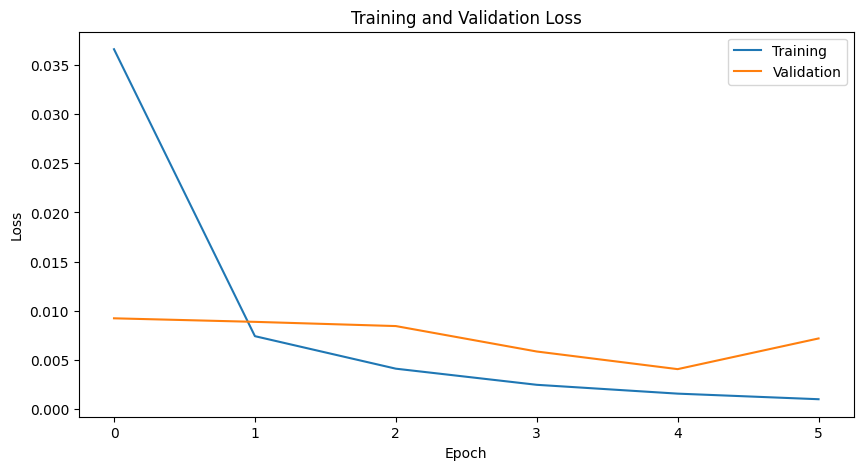

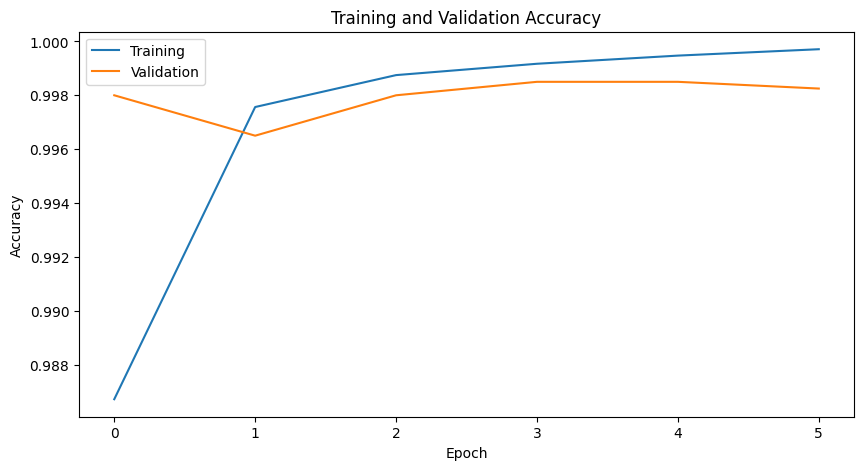

In [12]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Getting predictions for confusion matrix:   0%|          | 0/500 [00:00<?, ?it/s]

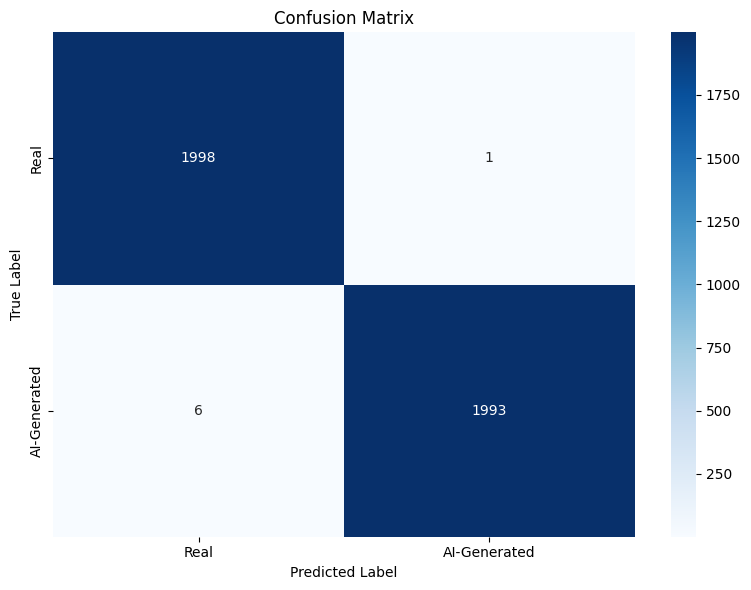

Accuracy: 0.9982
Precision: 0.9995
Recall: 0.9970
F1 Score: 0.9982


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Run validation to get predictions
model.eval()
val_pred_classes = []
val_labels_list = []

with torch.no_grad():
    for data, label in tqdm(val_loader, desc=f"Getting predictions for confusion matrix"):
        data, label = data.to(device), label.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        val_pred_classes.extend(preds.cpu().numpy())
        val_labels_list.extend(label.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(val_labels_list, val_pred_classes)
class_names = ['Real', 'AI-Generated']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
